In [102]:
import gym, time
import numpy as np
from stable_baselines3 import SAC
from gym_unbalanced_disk import UnbalancedDisk
from gym_unbalanced_disk import *
from gym import spaces

# def normalization(theta):
#     return (theta+np.pi)%(2*np.pi) - np.pi

# def get_diff(theta,target):
#     return 2*np.pi-np.abs(theta-target) if np.abs(theta-target)>np.pi else np.abs(theta-target)

# class UnbalancedDisk_multi(UnbalancedDisk):  # 应该可以用Wrapper来覆盖以及继承env吧。用熟悉的方法改写。 然后就是设计 reward，试试分段，不行就多查查。
#     """limit theta to [-pi,pi]"""
#     # observation [theta,omega,target]
#     def __init__(self, umax=3., dt = 0.025):
#         super(UnbalancedDisk_multi, self).__init__(umax=umax, dt=dt)
#         low = [-np.pi,-40.,-np.pi]
#         high = [np.pi,40.,np.pi]
#         weight_omega, weight_action = 0.15, 1e-3
#         self.observation_space = spaces.Box(low=np.array(low,dtype=np.float32),high=np.array(high,dtype=np.float32),shape=(3,))
#         self.reward_fun = lambda self: (-150*(get_diff(normalization(self.target),normalization(self.th)))**2 - weight_omega *self.omega **2 - weight_action*self.u**2).item()
#         self.count = 0

#     def get_obs(self):  # 他怎么没改step函数，后面还调用step》？
#         self.th_noise = self.th + np.random.normal(loc=0,scale=0.001) #do not edit
#         self.omega_noise = self.omega + np.random.normal(loc=0,scale=0.001) #do not edit
#         self.target = np.pi 
#         self.target = normalization(self.target)
#         self.theta = normalization(self.th_noise)
#         return np.array([self.theta, self.omega_noise, self.target]) #change anything here

#     def reset(self):
#         self.th = np.random.normal(loc=0, scale=0.001)
#         self.omega = np.random.normal(loc=0, scale=0.001)
#         self.u = 0
#         self.count = -1
#         return self.get_obs()


In [103]:
import gym, time
import numpy as np
from stable_baselines3 import SAC
from gym_unbalanced_disk import UnbalancedDisk
from gym_unbalanced_disk import *
from gym import spaces

def normalize(theta):
    return (theta+np.pi)%(2*np.pi) - np.pi

class Multi_target(UnbalancedDisk):
    def __init__(self, umax=3., dt = 0.025, target= np.pi):  # observation [angle,omega,target satisfy info]  target satisfy info: inside area 1, out -1, 也许0？
        self.target = target
        self.statu_left = 0
        self.statu_right = 0
        super(Multi_target,self).__init__(umax=umax, dt=dt) # use SAC do not need discretize action 
        low  = [-np.pi,-40.,-np.pi]
        high = [np.pi,40.,np.pi]
        self.observation_space = spaces.Box(low=np.array(low,dtype=np.float32),high=np.array(high,dtype=np.float32),shape=(3,))
        
    
    def get_obs(self):
        self.th_noise = self.th + np.random.normal(loc=0,scale=0.001) #do not edit
        self.omega_noise = self.omega + np.random.normal(loc=0,scale=0.001) #do not edit
        self.th_noise =normalize(self.th_noise)

        if abs(self.th -(np.radians(10)-np.pi))<0.001: # next to left target
            self.statu_left = 1
        if abs(self.th -(np.pi-np.radians(10)))<0.001: # next to right target
            self.statu_right = 1
        self.target = self.task_switch()
        self.obs = np.array([self.th_noise, self.omega_noise,self.target])
        return np.array([self.th_noise, self.omega_noise,self.target])

    def task_switch(self):
        if normalize(self.th)< np.radians(10)-np.pi or normalize(self.th)> np.pi-np.radians(10): # in the area
            if self.statu_left ==0 and self.statu_right==0: # didn't reach left.
                target = np.radians(10)-np.pi # left target  设置一个计数器，达成left 指定为1，也设定right 计数器！
            if self.statu_left ==1 and self.statu_right==0: # reach left
                target = np.pi - np.radians(10) # right target
                print('Left reach')
            if self.statu_left == 1 and self.statu_right ==1:
                target = np.radians(10)-np.pi
                self.statu_left = 0  # reset
                self.statu_right = 0
                print('Right reach')
        else:
            target = np.pi
        if target != self.target:
            print(f"Target shift happens: {target}")
        return target

    def reset(self):
        self.th = np.random.normal(loc=0,scale=0.001)
        self.omega = np.random.normal(loc=0,scale=0.001)
        self.u = 0
        return self.get_obs()
    
    def reward_fun(self):
        theta = self.obs[0]
        action = self.u
        if abs(theta-self.target)>np.pi: # superior arcs and inferior arcs  优弧 劣弧 问题
            diff = 2*np.pi-abs(theta-self.target)
        else:
            diff = abs(theta-self.target)

        reward_th =  np.exp(- (diff)**2/(2*(np.pi/10)**2))
        
        ## reward one, stuck at low level
        # if np.pi-abs(theta) < np.radians(10): # inside target area
        #     reward= reward_th +10 - 0.01*self.omega**2  # u [-3,3] + (3-abs(action))+5
        
        # elif  abs(theta)<1/3*np.pi and self.omega**2<0.25 :
        #     reward = reward_th + 0.01*self.omega**2 -2  # + abs(action) - 3 +
        # else: # outside target area
        #    reward= reward_th + 5
        
        ## reward 2 
        if np.pi-abs(theta) < np.radians(90):
            reward = -150*diff**2  -0.1*self.omega**2 -  1e-3*action**2
        elif np.pi-abs(theta) < np.radians(10):
            reward = -150*diff**2  -0.3*self.omega**2 -  3e-3*action**2
        else:
            reward = -150*diff**2  - 0.05*self.omega**2 -  1e-3*action**2
        
        ## reward 3 , swing up but cannot stop
        # reward=-150*diff**2 - 0.15* self.omega**2 - 1e-3*action**2
        
        return reward
        

        

In [104]:
#max_episode_steps = 20000
#env = UnbalancedDisk_multi(dt=0.025, umax=3.)


max_episode_steps = 1000
#env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3.)
env = Multi_target(umax=3., dt = 0.025,target= np.pi)
env = gym.wrappers.time_limit.TimeLimit(env, max_episode_steps=max_episode_steps)
#model = SAC.load('model/SAC_multi_best.zip')

model = SAC("MlpPolicy", env, learning_rate=0.01, verbose=1)
model.learn(total_timesteps=5000)
model.save('model/SAC_Multi_5000')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
obs = env.reset()
angle_ = []
target_ = []
reward_ = []
cum_reward_ = []
cum_rew = 0
try:
    # for i in range(5000):
    #     iteration = (i//200)%3
    #     if iteration == 0:
    #         target = np.pi
    #     elif iteration == 1:
    #         target = np.pi - np.radians(10)
    #     else: 
    #         target = np.pi + np.radians(10)
    #     obs[2] = normalize(target)
    for i in range(5000):
        action, _states = model.predict(obs)  # policy
        obs, reward, done, info = env.step(action)  # interact
        env.render()
        print(f'target = {obs[2]: .4f}, theta = {obs[0]: .4f}')
        time.sleep(1/120)
        angle_.append(normalize(obs[0]))
        target_.append(obs[2])
        reward_.append(reward)
        cum_rew += reward
        cum_reward_.append(cum_rew)
finally:
    env.close()

target =  3.1416, theta = -0.0241
target =  3.1416, theta = -0.0416
target =  3.1416, theta = -0.0377
target =  3.1416, theta = -0.0626
target =  3.1416, theta = -0.0793
target =  3.1416, theta = -0.0775
target =  3.1416, theta = -0.1075
target =  3.1416, theta = -0.1195
target =  3.1416, theta = -0.0797
target =  3.1416, theta = -0.0415
target =  3.1416, theta = -0.0261
target =  3.1416, theta = -0.0207
target =  3.1416, theta = -0.0520
target =  3.1416, theta = -0.0700
target =  3.1416, theta = -0.0750
target =  3.1416, theta = -0.0706
target =  3.1416, theta = -0.0243
target =  3.1416, theta =  0.0069
target =  3.1416, theta = -0.0154
target =  3.1416, theta = -0.0330
target =  3.1416, theta = -0.0308
target =  3.1416, theta = -0.0596
target =  3.1416, theta = -0.0796
target =  3.1416, theta = -0.0774
target =  3.1416, theta = -0.1000
target =  3.1416, theta = -0.1118
target =  3.1416, theta = -0.0922
target =  3.1416, theta = -0.0473
target =  3.1416, theta = -0.0087
target =  3.14

KeyboardInterrupt: 

In [ ]:
# obs = env.reset()
# angle_ = []
# target_ = []
# reward_ = []
# cum_reward_ = []
# cum_rew = 0
# try:
#     for i in range(5000):
#         iteration = (i//200)%3
#         if iteration == 0:
#             target = np.pi
#         elif iteration == 1:
#             target = np.pi - np.radians(10)
#         else: 
#             target = np.pi + np.radians(10)
#         obs[2] = normalization(target)
#         action, _states = model.predict(obs)
#         obs, reward, done, info = env.step(action)
#         env.render()
#         print(f'target = {obs[2]: .4f}, theta = {obs[0]: .4f}')
#         time.sleep(1/120)
#         angle_.append(normalization(obs[0]))
#         target_.append(obs[2])
#         reward_.append(reward)
#         cum_rew += reward
#         cum_reward_.append(cum_rew)
# finally:
#     env.close()

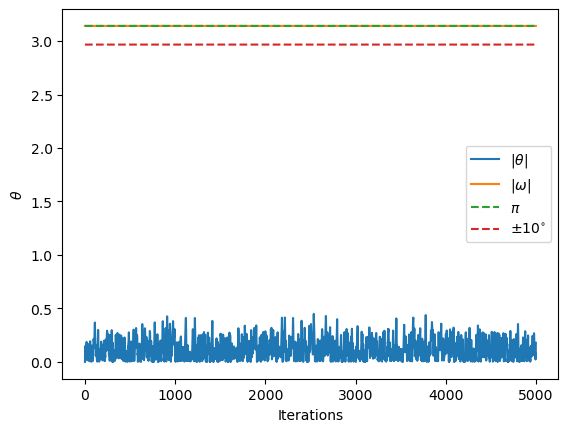

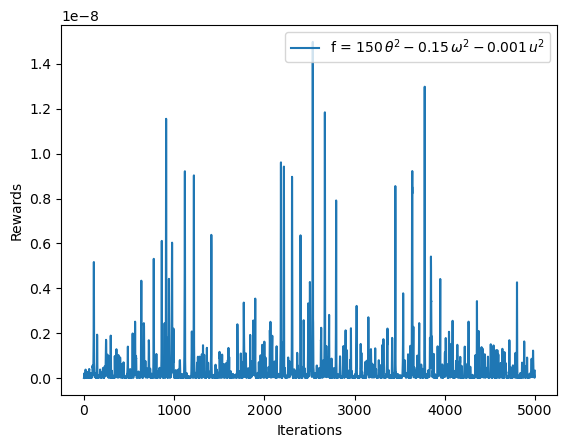

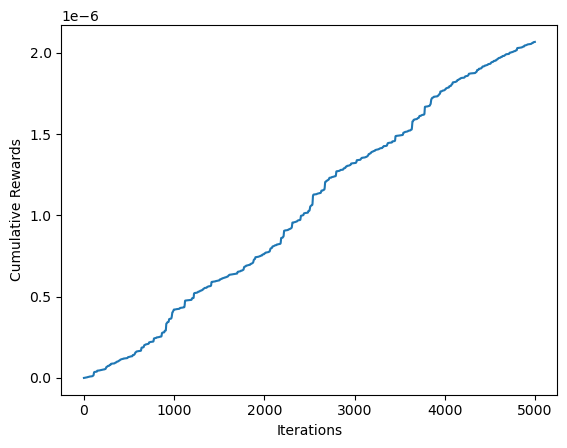

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.abs(angle_),label='$|\\theta|$')
plt.plot(np.abs(target_),label='$|\omega|$')
plt.plot([np.pi]*len(target_),'--',label='$\pi$')
plt.plot([np.pi-np.radians(10)]*len(target_),'--',label='$\pm10^{\circ}$')
plt.xlabel('Iterations')
plt.ylabel(r'$\theta$')
plt.legend()
plt.show()

plt.plot(reward_, label='f = $150\,\\theta^2 - 0.15\,\omega^2 - 0.001\,u^2$')
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.legend()
plt.show()

plt.plot(cum_reward_)
plt.xlabel('Iterations')
plt.ylabel('Cumulative Rewards')
plt.show()